In [53]:
import pandas as pd
import numpy as np
import scipy.io
import math
from collections import Counter
import copy
import warnings
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [54]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]
def rms(arr):
    n = len(arr)
    squared = np.array(arr) * np.array(arr)
    sum = np.sum(squared)
    mean = (sum / (float)(n))
    root = math.sqrt(mean)
    return root
def mav(arr):
    n = len(arr)
    mav = sum((abs(np.array(arr))))/(float)(n)
    return mav
def var(arr):
    n = len(arr)
    squared = np.array(arr) * np.array(arr)
    sum = np.sum(squared)
    result = (sum / (float)(n))
    return result
def wl(arr):
    n = len(arr)
    sum = 0
    for i in range(1, n):
        sum += abs(arr[i] - arr[i - 1])
    return sum
def iav(arr):
    return sum(abs(np.array(arr)))
def mean(arr):
    return np.sum(arr)/len(arr)
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):

            pretty(value, indent + 2)
            print('-----------------------')
        else:
            print('\t' * (indent + 2) + str(value))
            print(" ")
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)
def extractSubject(name):
    ex1Path = 'DB1/' + name + '/' + name + '_A1_E1.mat'
    print(ex1Path)
    ex1 = scipy.io.loadmat(ex1Path)
    emg = ex1['emg']
    EMGdf = pd.DataFrame.from_dict(emg)
    stimulus = ex1['restimulus']

    ex2Path = 'DB1/' + name + '/' + name + '_A1_E2.mat'
    ex2 = scipy.io.loadmat(ex2Path)
    emg2 = ex2['emg']
    EMGdf2 = pd.DataFrame.from_dict(emg2)
    stimulus2 = ex2['restimulus']

    ex3Path = 'DB1/' + name + '/' + name + '_A1_E3.mat'
    ex3 = scipy.io.loadmat(ex3Path)
    emg3 = ex3['emg']
    EMGdf3 = pd.DataFrame.from_dict(emg3)
    stimulus3 = ex3['restimulus']

    Movements = {}
    for m in range(1, 51):
        if (m < 11):
            movementIndices = np.where(stimulus == m)[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf
        elif (m < 28):
            movementIndices = np.where(stimulus2 == (m - 10))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf2
        else:
            movementIndices = np.where(stimulus3 == (m - 27))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf3

        Electrodes = {}
        for e in range(1, 11):
            temp = {}
            for r in range(1, 7):
                startIndex = repetitions[r - 1][0]
                LastIndex = repetitions[r - 1][len(repetitions[r - 1]) - 1]
                df = EMG.iloc[startIndex:LastIndex, e - 1]
                df.reset_index(drop=True, inplace=True)
                narray = df.to_numpy(dtype=None, copy=False)
                temp["R{0}".format(r)] = narray
            Electrodes["Electrode{0}".format(e)] = temp
        Movements["Movement{0}".format(m)] = Electrodes
    return Movements
def extractSubjectAngles(name):
    ex1Path = 'Kinematics/' + name + '/' + name + '_E1_A1.mat'
    print(ex1Path)
    ex1 = scipy.io.loadmat(ex1Path)
    angles1 = ex1['angles']
    anglesDF1 = pd.DataFrame.from_dict(angles1)
    stimulus = ex1['restimulus']

    ex2Path = 'Kinematics/' + name + '/' + name + '_E2_A1.mat'
    ex2 = scipy.io.loadmat(ex2Path)
    angles2 = ex2['angles']
    anglesDF2 = pd.DataFrame.from_dict(angles2)
    stimulus2 = ex2['restimulus']

    ex3Path = 'Kinematics/' + name + '/' + name + '_E3_A1.mat'
    ex3 = scipy.io.loadmat(ex3Path)
    angles3 = ex3['angles']
    anglesDF3 = pd.DataFrame.from_dict(angles3)
    stimulus3 = ex3['restimulus']

    Movements = {}
    for m in range(1, 51):
        if (m < 11):
            movementIndices = np.where(stimulus == m)[0]
            repetitions = consecutive(movementIndices)
            angle = anglesDF1
        elif (m < 28):
            movementIndices = np.where(stimulus2 == (m - 10))[0]
            repetitions = consecutive(movementIndices)
            angle = anglesDF2
        else:
            movementIndices = np.where(stimulus3 == (m - 27))[0]
            repetitions = consecutive(movementIndices)
            angle = anglesDF3

        Angles = {}
        for a in range(1,23):
            if a == 6:
               Angles["Angle6"] = ""
               continue

            temp={}
            for r in range(1, 7):
                startIndex = repetitions[r - 1][0]
                LastIndex = repetitions[r - 1][len(repetitions[r - 1]) - 1]
                df = angle.iloc[startIndex:LastIndex, a-1]
                df.reset_index(drop=True, inplace=True)
                narray = df.to_numpy(dtype=None, copy=False)
                temp["R{0}".format(r)] = narray
            Angles["Angle{0}".format(a)] = temp
        Movements["Movement{0}".format(m)] = Angles

    return Movements


In [55]:
final_df = pd.DataFrame(columns={'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
                                 'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
                                 'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
                                 'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
                                 'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
                                 'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
                                 'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
                                 'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
                                 'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
                                 'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
                                 'Train'})
final_df_angle = pd.DataFrame(columns={})
df_angle = pd.DataFrame(columns={})
i=0
for s in range(1,2):
    subject = 'S' + str(s)
    df_angles = pd.DataFrame.from_dict(extractSubjectAngles(subject))
    for m in range(1,51):
        M = df_angles['Movement'+str(m)]
        start = copy.deepcopy(i)
        for a in range (1,23):
            if a==6:
                continue

            Angles = M['Angle' +str(a)]
            for r in range(1,7):
                rep = "R" + str(r)
                for x in range(0, len(Angles[rep]), 48):
                    df_angle.at[i, a-1] = mean(Angles[rep][x:x + 50])
                    i += 1
            if a != 22:
                i = copy.deepcopy(start)
    final_df_angle = final_df_angle.append(df_angle, ignore_index=True)            

Kinematics/S1/S1_E1_A1.mat


In [56]:
for s in range(1,2):
    subject = 'S' + str(s)
    dff = pd.DataFrame.from_dict(extractSubject(subject))
    df = pd.DataFrame(columns={'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
                           'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
                           'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
                           'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
                           'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
                           'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
                           'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
                           'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
                           'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
                           'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
                           'Train'})
    for e in range(1, 11):
        electrode = 'Electrode' + str(e)
        i=0
        for m in range(1,51):
            M = dff['Movement'+str(m)][electrode]
            for r in range(1, 7):
                rep = "R" + str(r)
                if (r in [1, 3, 4, 6]):
                    train = 1
                else:
                    train = 0
                for x in range(0, len(M[rep]), 48):
                    df.at[i, 'RMS' + str(e)] = rms(M[rep][x:x + 50])
                    df.at[i, 'MAV' + str(e)] = mav(M[rep][x:x + 50])
                    df.at[i, 'VAR' + str(e)] = var(M[rep][x:x + 50])
                    df.at[i, 'WL' + str(e)] = wl(M[rep][x:x + 50])
                    df.at[i, 'IAV' + str(e)] = iav(M[rep][x:x + 50])
                    df.at[i, 'Train'] = train
                    i += 1
    final_df = final_df.append(df, ignore_index=True)

DB1/S1/S1_A1_E1.mat


In [90]:
final_df['CMC1_f'] = df_angle[0]
final_df['CMC1_a'] =  df_angle[1]
final_df['MCP1'] =  df_angle[2]
final_df['IP1'] =  df_angle[3]
final_df['MCP2_f'] =  df_angle[4]
final_df['PIP2'] =  df_angle[6]
final_df['MCP3_f'] =  df_angle[7]
final_df['PIP3'] =  df_angle[8]
final_df['MCP4_f'] =  df_angle[9]
final_df['MCP4_a'] =  df_angle[10]
final_df['PIP4'] =  df_angle[11]
final_df['CMC5'] =  df_angle[12]
final_df['MCP5_f'] =  df_angle[13]
final_df['MCP5_a'] =  df_angle[14]
final_df['PIP5'] =  df_angle[15]
final_df['DIP2'] =  df_angle[16]
final_df['DIP3'] =  df_angle[17]
final_df['DIP4'] =  df_angle[18]
final_df['DIP5'] =  df_angle[19]
# final_df['WRIST_F'] =  df_angle[20]
# final_df['WRIST_A'] =  df_angle[21]

features = {
            'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
            'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
            'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
            'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
            'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
            'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
            'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
            'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
            'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
            'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10' }

angles = {'CMC1_f','CMC1_a','MCP1','IP1','MCP2_f',
        'PIP2','MCP3_f','MCP4_f','MCP4_a',
        'PIP4','CMC5','MCP5_f','MCP5_a','PIP5',
        'DIP2','DIP4','DIP5', 'DIP3', 'PIP3'}

print(final_df)

         WL5      MAV8     WL2     IAV8    IAV9      MAV2      RMS2      RMS6  \
0      0.005  0.053168   0.696   2.6584  2.0183  0.061522  0.078694    0.0024   
1      0.059  0.084324  0.4956   4.2162  2.5488  0.083688  0.091641  0.002922   
2     0.0246  0.062058  0.0707   3.1029  1.0291  0.008616  0.014363  0.003056   
3      0.015   0.03213     0.0   1.6065   0.516    0.0024    0.0024    0.0024   
4      0.005   0.04868     0.0    2.434  1.3248    0.0024    0.0024    0.0024   
...      ...       ...     ...      ...     ...       ...       ...       ...   
2330  0.1955  0.943456  0.5612  47.1728    7.29  0.238432   0.24126  0.030836   
2331  0.4544  0.856448  0.6469  42.8224   7.549  0.197262  0.201787  0.035822   
2332  0.3053    0.5295  0.7881   26.475  7.1026  0.144046  0.150342  0.023503   
2333  0.3393  1.025882  0.6471  51.2941  6.8313  0.102876  0.143653  0.064262   
2334   0.105  0.339236  0.0074   7.4632  3.4157  0.002736  0.003141  0.063151   

          MAV3   IAV10  ...

In [91]:
X_train = final_df[final_df['Train'] == 1].loc[:, features]
scalar =  StandardScaler()
scalar = scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = final_df[final_df['Train'] == 0].loc[:, features]
X_test = scalar.transform(X_test)

y_train = final_df[final_df['Train'] == 1].loc[:, angles]
y_test = final_df[final_df['Train'] == 0].loc[:, angles]
y_test.to_csv('angles_y_test.csv')

In [93]:
input = Input(shape =(10,))
L1 = Dense(500, activation='tanh')(input)
L2 = Dense(500, activation='sigmoid')(L1)
# L3 = Dense(100, activation='sigmoid')(L2)
ouput = Dense(19, activation='linear')(L2)
model = Model(input, ouput)
model.compile(optimizer=Adam(learning_rate=0.002), loss="mean_squared_error", metrics=['mae', 'mse'])
model.fit(X_train, y_train, epochs=1000)
print(model.evaluate(X_test, y_test))




Epoch 1/1000
48/48 [==============================] - 0s 1ms/step - loss: 1031.9425 - mae: 19.0036 - mse: 1031.9425
Epoch 2/1000
48/48 [==============================] - 0s 2ms/step - loss: 733.1552 - mae: 16.8048 - mse: 733.1552
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 673.2225 - mae: 16.4048 - mse: 673.2225
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 653.3138 - mae: 16.2417 - mse: 653.3138
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 636.7527 - mae: 16.0506 - mse: 636.7527
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 626.8224 - mae: 15.9961 - mse: 626.8224
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 614.9625 - mae: 15.8530 - mse: 614.9625
Epoch 8/1000
48/48 [==============================] - 0s 2ms/step - loss: 606.5449 - mae: 15.6947 - mse: 606.5449
Epoch 9/1000
48/48 [==============================] - 0s 1ms/step - loss: 595.9734 - m

In [94]:
predicted = model.predict(X_test)
y_test.reset_index(drop=True, inplace=True)
columns = ['MCP5_f','DIP5','DIP2','MCP1','PIP3','DIP4','CMC1_a','CMC1_f','PIP4','MCP4_f','PIP2','DIP3','CMC5','PIP5','IP1','MCP3_f','MCP2_f','MCP4_a','MCP5_a']
Error = pd.DataFrame(columns=columns)
length = y_test.shape[0]
for i in range (0,length):
    print(abs(predicted[i]))
    Error.at[i,:] = abs(abs(predicted[i])-abs(y_test.iloc[i,:]))



[27.041157   5.0306425  2.3502138 44.31801   21.35016   14.053967
 10.601139  64.591125  13.589849   2.284122   3.101419  14.427555
  6.674815  14.517036  14.3600445  2.6957064 12.9877205  7.6212573
 28.776026 ]
[ 3.5224583  9.355375  91.57949   40.96191   16.841185  50.268715
 16.43992   21.141302  13.841068   3.7838116  7.9169316 11.242289
  4.8242865  2.3652139 15.29051    3.0085723  8.321451   5.338957
 29.770426 ]
[49.058186   2.8871045 68.05407   57.3899     1.4666262 44.684063
  9.877258  12.869142  18.18296    8.0445175  2.9159827 15.394163
  1.8015563 26.24653   13.795612   2.486811   1.94273    6.9774184
 33.19391  ]
[ 8.577288    1.8914684  50.222706   30.453922    0.07331601 26.034634
 14.779898    7.4762487   0.42102253  2.5217214   5.037119    8.1266775
  3.6681833  14.735782    2.2526793   0.14354804 12.974998    6.967304
 12.343412  ]
[ 9.32694     2.884151   43.230904   38.350796    2.5522933  22.985859
  5.6301756  25.922888   13.067496    1.6394477   2.7183      8.95

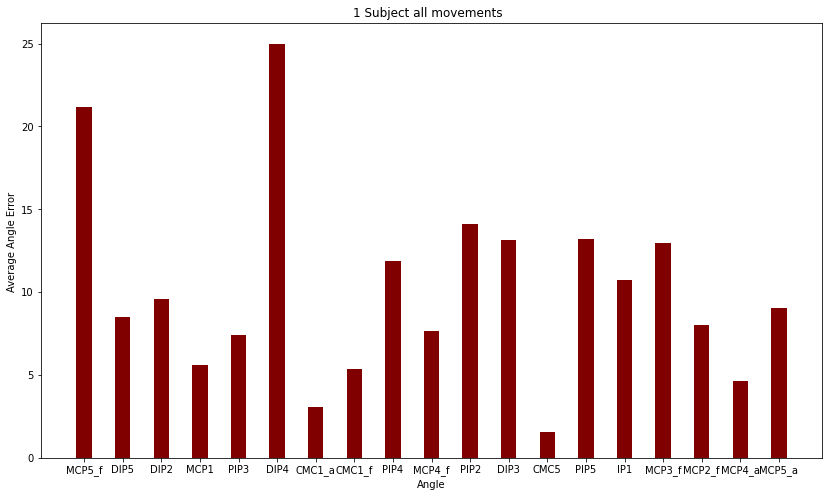

In [95]:
Error.to_csv('error_test1.csv')   
Error.mean()
fig = plt.figure(figsize=(14, 8))
 
# creating the bar plot
plt.bar(columns, Error.mean(), color ='maroon',
        width = 0.4)
 
plt.xlabel("Angle")
plt.ylabel("Average Angle Error ")
plt.title("1 Subject all movements  ")
plt.show()
